In [1]:
from jobflow import SETTINGS
from tqdm.auto import tqdm
from emmet.core.tasks import TaskDoc


/ocean/projects/dmr110014p/ychiang4/.conda/envs/comm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pymatgen.io.vasp import Incar
import pandas as pd

store = SETTINGS.JOB_STORE
store.connect()

response = store.query(
    # custom label for filtering
    {
        "output.project": "bm-bridges2-vasp",
        "output.version": "0.0.1", 
        # "name":  {"$regex": ".*static"}
    }, 
    properties=["output"],
    load=True,
)

stats = []

df = pd.DataFrame()

for i, doc in tqdm(enumerate(response)):

    task_doc = TaskDoc(**doc["output"])

    incar = Incar.from_file(task_doc.calcs_reversed[-1].dir_name + "/INCAR.gz")

    row = {
        "nodes": doc['output']['resources']['nodes'],
        "NCORE": incar.as_dict()["NCORE"],
        "KPAR": incar.as_dict()["KPAR"],
        "total_time": task_doc.calcs_reversed[0].output.run_stats.total_time
    }
    stats.append(row)

    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

0it [00:00, ?it/s]/ocean/projects/dmr110014p/ychiang4/.conda/envs/comm/lib/python3.12/site-packages/pymatgen/io/vasp/inputs.py:908: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
90it [00:07, 11.85it/s]


In [3]:
df

,nodes,NCORE,KPAR,total_time
0,8,1,16,3524.334
1,8,2,2,2409.598
2,8,2,8,2289.521
3,8,4,2,1929.898
4,8,4,8,2421.131
...,...,...,...,...
85,16,4,1,4659.927
86,16,4,16,2427.840
87,16,8,1,2315.431
88,16,8,4,1254.092


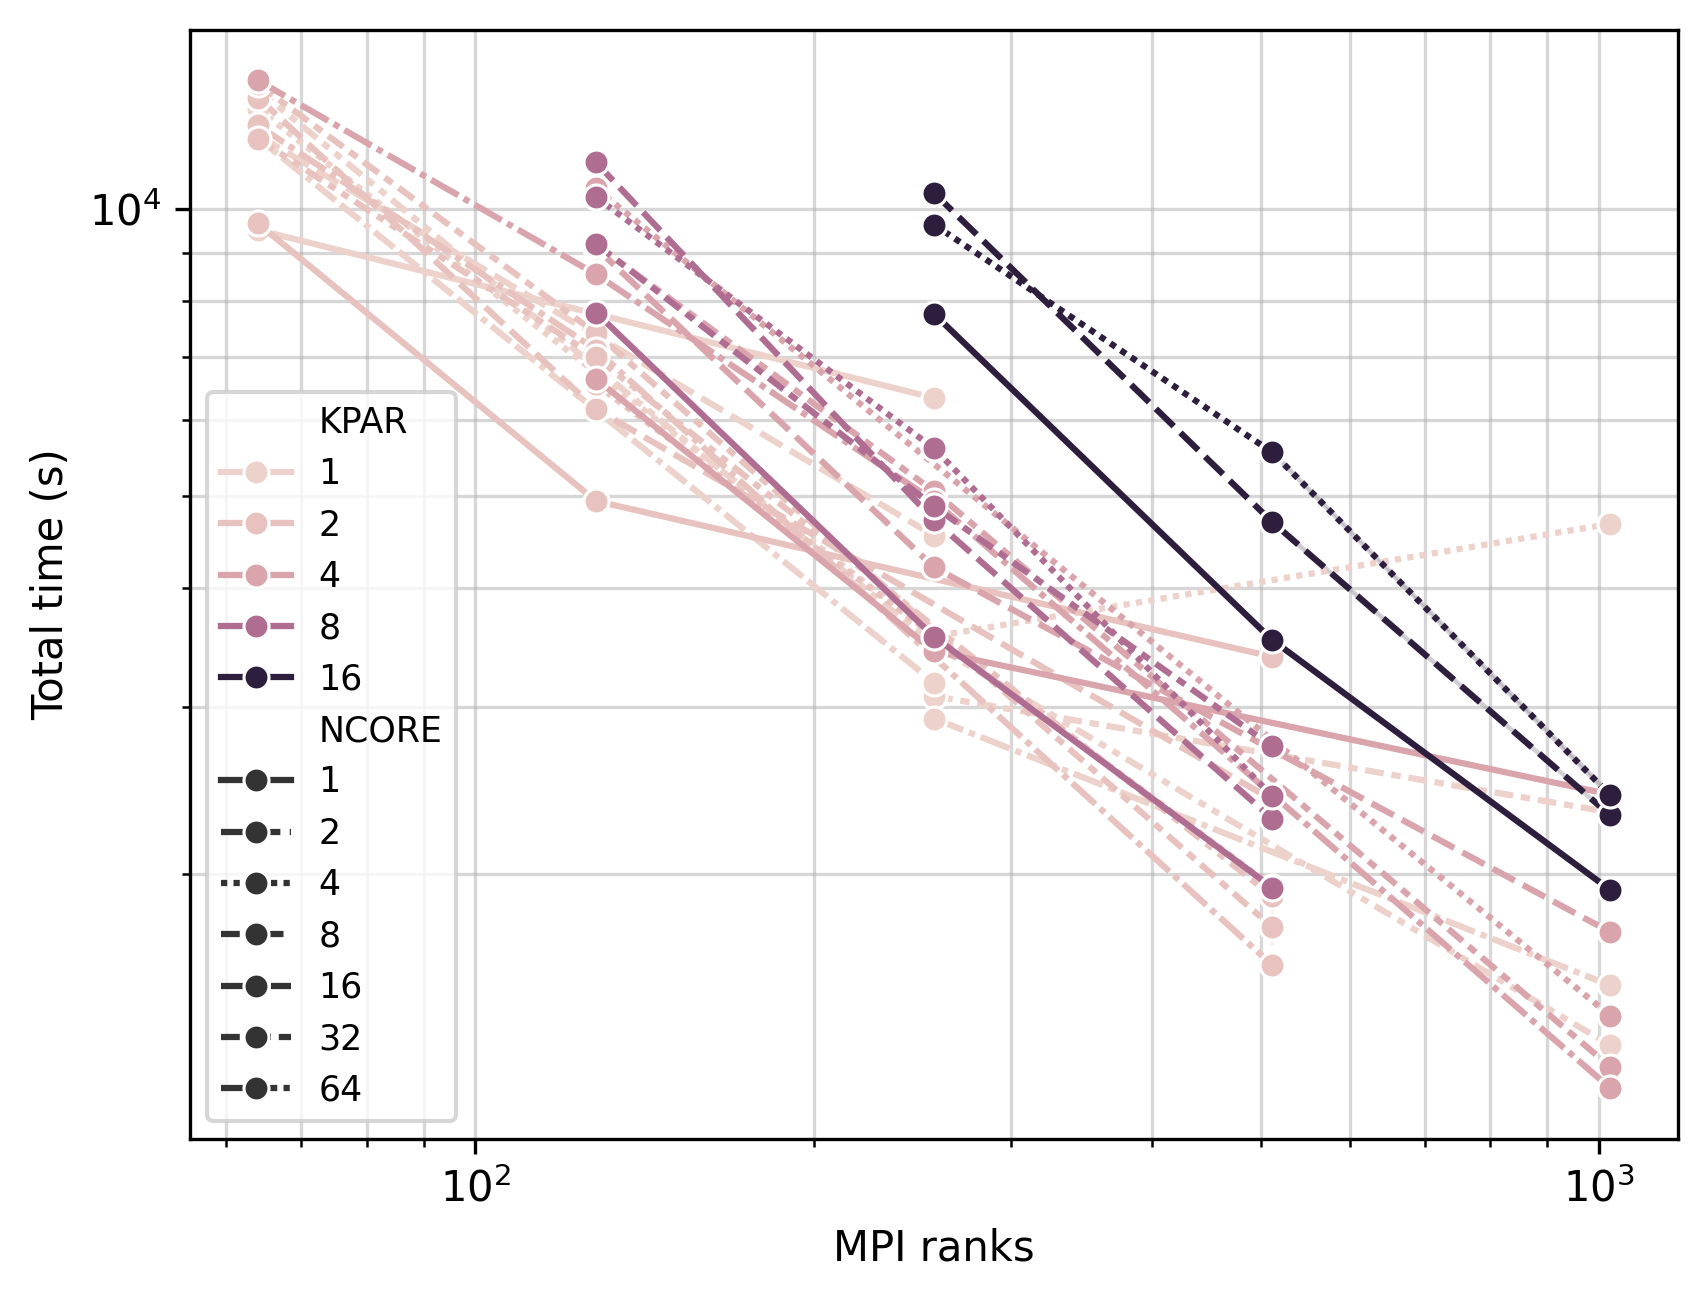

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

df['num_processes'] = df['nodes'] * 64

plt.figure(
    dpi=300
)
ax = sns.lineplot(
    data=df, 
    x='num_processes', y='total_time', 
    hue='KPAR', style='NCORE',
    marker='o',
)
ax.set(
    # title='Effect of NCORE on Total Time',
    xlabel='MPI ranks',
    # xlabel='Number of processes (ntasks_per_node $\\times$ nodes)',
    ylabel='Total time (s)',
    xscale='log', yscale='log'
)

# handles, labels = ax.get_legend_handles_labels()
# ax._legend.remove()
# ax.fig.legend(handles, labels, ncol=2, loc='upper center', 
#                 bbox_to_anchor=(0.5, 1.15), frameon=False)
# plt.legend(title='Nodes and NCORE')
ax.legend(fontsize='small')
ax.grid(True, which='both', alpha=0.5)
plt.show()


In [5]:
df[df['total_time']==df['total_time'].min()]

,nodes,NCORE,KPAR,total_time,num_processes
22,16,16,4,1191.268,1024
